In [ ]:
%matplotlib inline

import numpy as np
from scipy.signal import convolve2d
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import glob
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from IPython.display import Math

np.random.seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

In [ ]:
from google.colab import files

In [ ]:
uploaded = files.upload()

In [ ]:
uploaded = files.upload()

In [ ]:
# Точное значение критической Т для 2D модели Изинга с 4 соседями

Tc = 2.0/np.log(1.+2**0.5)



In [ ]:
def get_lattices(T):
  lattices = []
  with open("/content/gdrive/MyDrive/data/" + str(T) + ".txt", "r") as ins: 
      lattice = []
      for line in ins:
        lattice = [int(x) for x in line.split()] # считайте данные и запишите построчно lattice
        lattice = np.reshape(lattice, (10, 10))    #размер Вашей системы спинов
        lattices.append(lattice)
  return round(T,4), lattices

Ts = np.arange(5.00001, 0.100001, -0.1)
d_data = {}
for T in Ts:
  T1 = round(T, 5)
  print (T)
  print (T1)
  T1, lattices = get_lattices(T1)
  d_data[T1] = lattices
  print (d_data[T1])


In [ ]:
lattices2 = []

lt = [0 for c in range(50)] #Temp
lm = [0 for c in range(50)] #Magn
with open("/content/gdrive/MyDrive/output.txt", 'r') as ins: # файл содежит T E E_err M M_err
    lattice2 = []
    for line2 in ins:
        lattice2 = [(k) for k in line2.split()] # считайте данные и запишите построчно в lattice2
        lattice2 = np.resize(lattice2, (5,1,1))   # размер систем
        lattices2.append(lattice2)
#print(lattices2[1][3][0])

for l in range(50):
    for r in  range(0,1,3):
       # print(lattices2[l][r][0])
        lt[l]=float(lattices2[l][r][0])
   # print("\n")
print(lt)
for l in range(50):
    for r in  range(3,4,2):
       # print(lattices2[l][r][0])
        lm[l]=float(lattices2[l][r][0])
        
print(lm) 

In [ ]:
# создаем вектора  для входных/выходных данных и вектор температур
X_data = []
y_data = []
T_data = []
for T,configs in d_data.items():
    print(T)
    print(configs)
    for config in configs:
        # переворачиваем спины, чтобы удвоить датасет сохраняя E одинаковым
        # и это также необходимо, чтобы ML алгоритм  не переобучался
        # т.е. не начал предпочитать один знак намагничености системы другому, 
        # т.к. например все спины вверх и все вниз - это равновероятные конфигурации
        # с одинаковой Е,
        # а также зеркалируем решетку по горизонтали/вертикали, чтобы получить независимые данные.
        # Расставляем метки  (0 - низкотемпературная фаза, 1 - высокотемпературная фаза),

        label = 0 #Установите метку
        if T > Tc:
            label = 1 #Установите метку
            
        X_data.append(config)
        X_data.append(np.flip(config,0))
        X_data.append(np.flip(config,1))
        X_data.append(-config)
        X_data.append(-np.flip(config,0))
        X_data.append(-np.flip(config,1))
        
        for _ in range(6):# запишите число в range(??), чтобы каждому элементу X_data был сопоставлен T_data и y_data
            T_data.append(T) #Записать значение Т
            y_data.append(label) #Записать метку


X_data = np.array(X_data)
y_data = np.array(y_data)
T_data = np.array(T_data)

# переходим от -1,1 к 0,1
X_data = 0.5*(X_data+1)

# Таким образом, наши тренировочные и тестовые наборы данных будут состоять из 
# пиксельных "изображений" решеток состоящих из 0 и 1 для каждого спина.
# Затем определяем находится система при низкой (T<Tc) или высокой (T>Tc) температуре.
# Это позволит CNN изучить концепцию температуры/намагниченности/ и т.п.
# И на основе этого делать классификацию

In [ ]:
# Разделим данные
# Обучим только на очень высокотемпературных или  низкотемпературных конфигурациях, далеко от Tc.
# Следовательно, CNN попытается узнать критическую температуру из состояний, 
# которые находятся глубоко внутри любой из фаз.

X_train, X_test, y_train, y_test, T_train, T_test = train_test_split(X_data, y_data, T_data, test_size=0.3, random_state=42)

hl = np.abs(T_train-Tc)>1.5 # hl - условие определения high/low temp регионов для обучения
print(hl)
X_train = X_train[hl] # в X_train пересохранить только те, которые отвечают условию hl
y_train = y_train[hl] # в y_train пересохранить только те, которые отвечают условию hl 
T_train = T_train[hl] # в y_train пересохранить только те, которые отвечают условию hl
print ("Training samples: ", X_train.shape[0])
print ("Testing samples: ", X_test.shape[0])

In [ ]:
# Подготовим входные данные для CNN 
sys_rows, sys_cols = 10, 10 #размер Вашей системы
X_train = X_train.reshape(X_train.shape[0], sys_rows, sys_cols, 1)
X_test = X_test.reshape(X_test.shape[0], sys_rows, sys_cols, 1)
input_shape = (sys_rows, sys_cols, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = keras.utils.to_categorical(y_train, 2)
y_test = keras.utils.to_categorical(y_test, 2)

In [ ]:
# Создаем и обучаем модель
model = Sequential()
model.add(Conv2D(32, 
                 (3,3) #установите размер ядра 3х3
                 , 
                 activation="relu" #функция активации relu
                 ,
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2))) 
model.add(Dropout(0.2)) #0.2
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.3)) #0.3
model.add(Dense(16, activation="relu"))
model.add(Dropout(0.1)) #0.1
model.add(Dense(2, activation="relu"))

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=100,
                    epochs=6,
                    verbose=1,
                    shuffle=True,
                    validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=0)
print ('Test loss:', score[0])
print ('Test accuracy:', score[1])

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print ('Test loss:', score[0])
print ('Test accuracy:', score[1])

In [ ]:
# прогноз
pred = model.predict(X_test)
pred = pred[:,1]
y = y_test[:,1]

high = y > 0.5
low = y < 0.5

In [ ]:
def get_t_and_avgpred(Ts,preds):
#Для вектора температур и прогнозов мы возвращаем вектор уникальных температур 
#и их средний прогноз вместе со стандартной погрешностью
    new_Ts = []
    new_preds = []
    new_prederrs = []
    for T in np.unique(Ts):
        new_Ts.append(T)
        new_preds.append(preds[Ts == T].mean())
        new_prederrs.append(preds[Ts == T].std()/np.sqrt(len(preds[Ts == T])))
    return np.array(new_Ts), np.array(new_preds), np.array(new_prederrs)

def sigmoid(x, x0, k):
    return 1 / (1 + 1*np.exp(-k*(x-x0)))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Predicted Tc = 1.935
       Error = 14.74%


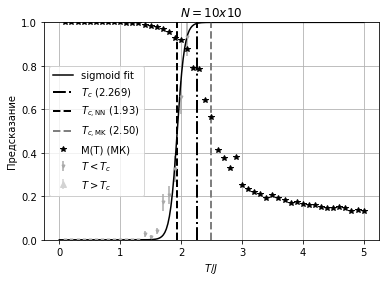

In [ ]:
# Результат -
# Строим средние прогнозы для решеток в тестовом наборе при разных температурах. 
# Точка, в которой предсказание проходит через 0.5 - критическая температура, 
# т.е. фазовый переход. Строим сигмоиду и используем её для оценки точки пересечения (`Tc_fit`)
Ts_low, preds_low, prederrs_low = get_t_and_avgpred(T_test[low],pred[low])
Ts_high, preds_high, prederrs_high = get_t_and_avgpred(T_test[high],pred[high])

# строим сигмойду
popt, pcov = curve_fit(sigmoid, np.r_[Ts_low,Ts_high], np.r_[preds_low,preds_high])
xfit = np.linspace(0.0,5.0,200)
yfit = sigmoid(xfit, *popt)
# и выясняем, для какого T линия ближе всего к 0.5
Tc_fit = xfit[np.argmin(np.abs(yfit-0.5))]
Tc_MK=2.5 # Поставьте значение, которое Вы получили после МК-моделирования

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.errorbar(Ts_low,preds_low, yerr=prederrs_low,linestyle='',marker='v',markersize=3,  color="darkgrey", label="$T<T_c$")
ax.errorbar(Ts_high,preds_high, yerr=prederrs_high,linestyle='',marker='^', color="lightgrey", label="$T>T_c$")
ax.plot(xfit,yfit, "k-", label="sigmoid fit")
ax.plot([Tc,Tc],[0.,1.],'-.', color="black",linewidth=2.0, label="$T_c$ ({:.3f})".format(Tc))
#print("{} {} {}\nI".format(Ts_low,preds_low, prederrs_low ))
ax.plot([Tc_fit,Tc_fit],[0.,1.0],'--', color="black",linewidth=2.0, label="$T_{{c,\mathrm{{NN}}}}$ ({:.2f})".format(Tc_fit))
ax.plot([Tc_MK,Tc_MK],[0.,1.0],'--', color="gray",linewidth=2.0, label="$T_{{c,\mathrm{{MK}}}}$ ({:.2f})".format(Tc_MK))
ax.plot(lt,lm,"k*", label="M(T) (МК)")
ax.set_xlabel("$T/J$")
ax.set_ylabel("Предсказание")
ax.set_ylim(0,1)
#ax.annotate("Парамагнитная фаза",xy=(0,0), xytext=(-1.1,1.1))
#ax.annotate("Ферромагнитная фаза",xy=(0,0), xytext=(-1.1,-0.1))
ax.set_title("$N = 10x10$")
ax.legend(loc ="center left")
ax.grid(True)


fig.savefig('мой график.eps')

print ("Predicted Tc = "+str(round(Tc_fit,3)))
print ("       Error =", str(round(np.abs(Tc_fit-Tc)/Tc*100,2))+"%")
